# MLP
Redo MLP_208 with better FILTER implementation.

Here, we filtered the tails from train and test. Use only the middle.

In [70]:
from datetime import datetime
print(datetime.now())

2023-03-28 15:06:57.937014


In [71]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [72]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=200 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = True
FILTER_TAILS_TRAIN  = True
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = True
FILTER_TAILS_TEST   = True
FILTER_MIDDLE_TEST  = False

Python 3.9.16
sklearn 1.2.2


In [73]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [74]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [75]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [76]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    layer3 = Dense(64, activation='sigmoid')
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(layer3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return mlp

In [77]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-28 15:06:59.102478
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_204 (Dense)           (None, 64)                65664     
                                                                 
 dense_205 (Dense)           (None, 64)                4160      
                                                                 
 dense_206 (Dense)           (None, 64)                4160      
                                                                 
 dense_207 (Dense)           (None, 1)                 65        
                                                                 
Total params: 74,049
Trainable params: 74,049
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [78]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            self.model.save(filename)
        
    def load_model(self,filename):
        self.model = keras.models.load_model(filename)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [79]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if not FILTER_TEST or \
                    (FILTER_TAILS_TEST and in_middle) or \
                    (FILTER_MIDDLE_TEST and in_tails):
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if not FILTER_TRAIN or \
                    (FILTER_TAILS_TRAIN and in_middle) or \
                    (FILTER_MIDDLE_TRAIN and in_tails):
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-28 15:06:59.265756
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-03-28 15:07:12.553716

Training # 1 1
2023-03-28 15:07:12.554356
2023-03-28 15:07:12.554411
Discriminator ZERO -1
Train 1:0 757:668 53.12%
Computed class weights: {0: 1.0666167664670658, 1: 0.9412153236459709}
Valid 1:0 178:150 54.27%
FIT
2023-03-28 15:07:12.613317


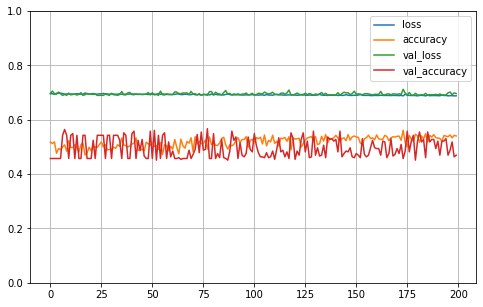


2023-03-28 15:07:42.332509

Testing # 1 1
2023-03-28 15:07:42.332559
2023-03-28 15:07:42.332609
PREDICT
2023-03-28 15:07:42.338460
Test 1:0 178:150 54.27%
Predict 1:0 176:152 53.66%
Test sizes (328, 1025) (328,)
Range of scores: 0.281806 to 0.5364661
Score threshold 0.5
Confusion matrix
 [[64 86]
 [88 90]]
Normalized matrix
 [[0.19512195 0.26219512]
 [0.26829268 0.27439024]]


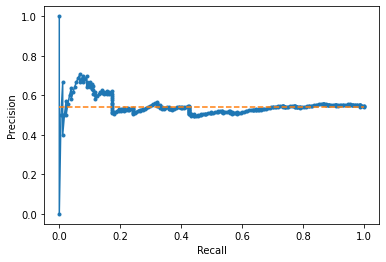

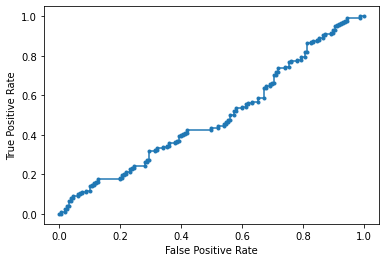

Accuracy: 46.95% Precision: 51.14% Recall: 50.56%
F1: 50.85% MCC: -0.0676
AUPRC: 54.60% AUROC: 49.10%
 accuracy [46.95121951219512]
 precision [51.13636363636363]
 recall [50.56179775280899]
 F1 [50.847457627118644]
 MCC [-0.0676495119192606]
 AUPRC [54.59999643867649]
 AUROC [49.09737827715356]
2023-03-28 15:07:42.871058

Training # 1 2
2023-03-28 15:07:42.871239
2023-03-28 15:07:42.871291
Discriminator ZERO -1
Train 1:0 742:639 53.73%
Computed class weights: {0: 1.0805946791862284, 1: 0.9305929919137467}
Valid 1:0 193:179 51.88%
FIT
2023-03-28 15:07:42.925029


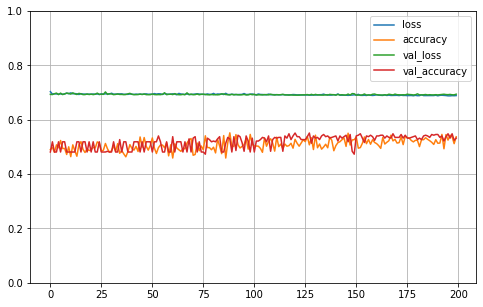


2023-03-28 15:08:13.377153

Testing # 1 2
2023-03-28 15:08:13.378533
2023-03-28 15:08:13.378883
PREDICT
2023-03-28 15:08:13.381846
Test 1:0 193:179 51.88%
Predict 1:0 217:155 58.33%
Test sizes (372, 1025) (372,)
Range of scores: 0.2669394 to 0.52211386
Score threshold 0.5
Confusion matrix
 [[ 80  99]
 [ 75 118]]
Normalized matrix
 [[0.21505376 0.26612903]
 [0.2016129  0.3172043 ]]


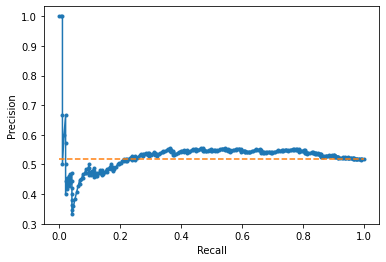

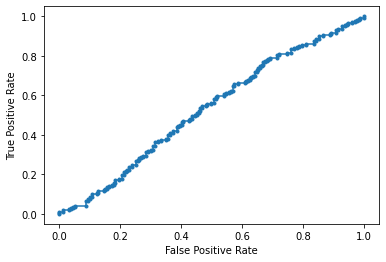

Accuracy: 53.23% Precision: 54.38% Recall: 61.14%
F1: 57.56% MCC: 0.0591
AUPRC: 53.03% AUROC: 53.16%
 accuracy [53.2258064516129]
 precision [54.377880184331794]
 recall [61.13989637305699]
 F1 [57.56097560975609]
 MCC [0.05911179732149028]
 AUPRC [53.028586099367516]
 AUROC [53.16235852606594]
2023-03-28 15:08:13.843256

Training # 1 3
2023-03-28 15:08:13.844206
2023-03-28 15:08:13.844299
Discriminator ZERO -1
Train 1:0 750:670 52.82%
Computed class weights: {0: 1.0597014925373134, 1: 0.9466666666666667}
Valid 1:0 185:148 55.56%
FIT
2023-03-28 15:08:13.897535


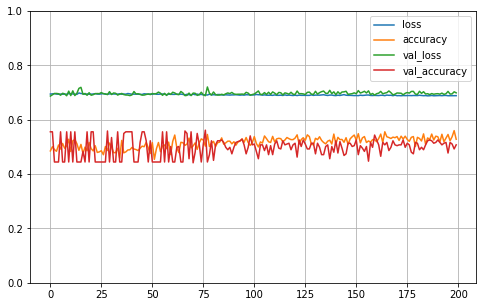


2023-03-28 15:08:55.963265

Testing # 1 3
2023-03-28 15:08:55.965736
2023-03-28 15:08:55.966117
PREDICT
2023-03-28 15:08:55.968856
Test 1:0 185:148 55.56%
Predict 1:0 201:132 60.36%
Test sizes (333, 1025) (333,)
Range of scores: 0.3016284 to 0.5302338
Score threshold 0.5
Confusion matrix
 [[ 58  90]
 [ 74 111]]
Normalized matrix
 [[0.17417417 0.27027027]
 [0.22222222 0.33333333]]


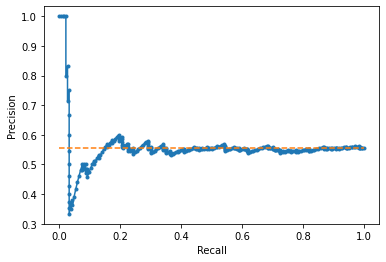

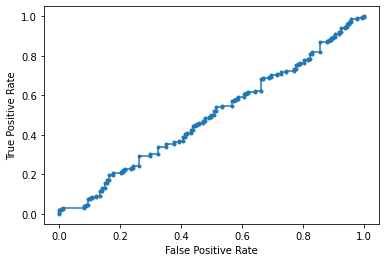

Accuracy: 50.75% Precision: 55.22% Recall: 60.00%
F1: 57.51% MCC: -0.0082
AUPRC: 55.70% AUROC: 49.22%
 accuracy [50.750750750750754]
 precision [55.223880597014926]
 recall [60.0]
 F1 [57.51295336787565]
 MCC [-0.008236662258223169]
 AUPRC [55.69735058779885]
 AUROC [49.22205989773558]
2023-03-28 15:08:56.419159

Training # 1 4
2023-03-28 15:08:56.419341
2023-03-28 15:08:56.419388
Discriminator ZERO -1
Train 1:0 744:639 53.80%
Computed class weights: {0: 1.0821596244131455, 1: 0.9294354838709677}
Valid 1:0 191:179 51.62%
FIT
2023-03-28 15:08:56.467502


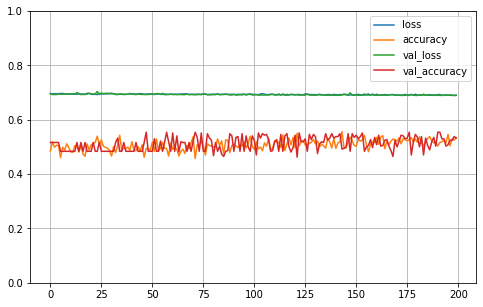


2023-03-28 15:09:38.874283

Testing # 1 4
2023-03-28 15:09:38.874655
2023-03-28 15:09:38.874688
PREDICT
2023-03-28 15:09:38.877540
Test 1:0 191:179 51.62%
Predict 1:0 244:126 65.95%
Test sizes (370, 1025) (370,)
Range of scores: 0.36264098 to 0.54241306
Score threshold 0.5
Confusion matrix
 [[ 66 113]
 [ 60 131]]
Normalized matrix
 [[0.17837838 0.30540541]
 [0.16216216 0.35405405]]


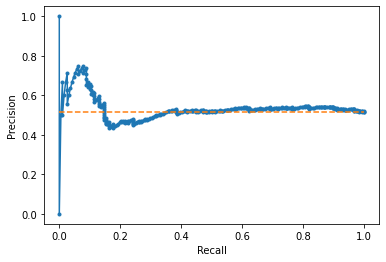

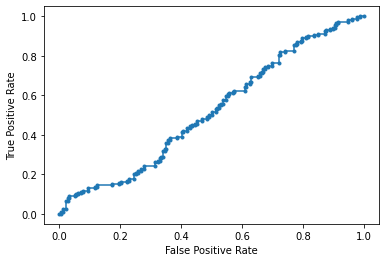

Accuracy: 53.24% Precision: 53.69% Recall: 68.59%
F1: 60.23% MCC: 0.0576
AUPRC: 53.23% AUROC: 51.93%
 accuracy [53.24324324324324]
 precision [53.68852459016394]
 recall [68.58638743455498]
 F1 [60.229885057471265]
 MCC [0.05755568864718359]
 AUPRC [53.229312876010624]
 AUROC [51.93483284097225]
2023-03-28 15:09:39.294263

Training # 1 5
2023-03-28 15:09:39.295386
2023-03-28 15:09:39.295578
Discriminator ZERO -1
Train 1:0 747:656 53.24%
Computed class weights: {0: 1.069359756097561, 1: 0.9390896921017403}
Valid 1:0 188:162 53.71%
FIT
2023-03-28 15:09:39.338830


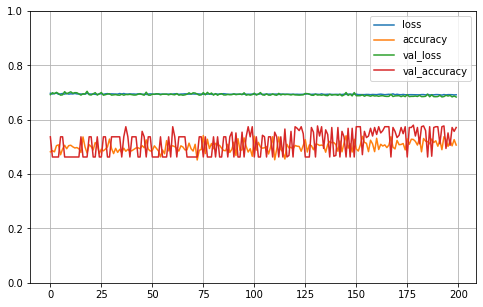


2023-03-28 15:10:06.943380

Testing # 1 5
2023-03-28 15:10:06.943789
2023-03-28 15:10:06.943826
PREDICT
2023-03-28 15:10:06.946780
Test 1:0 188:162 53.71%
Predict 1:0 304:46 86.86%
Test sizes (350, 1025) (350,)
Range of scores: 0.39577147 to 0.5533358
Score threshold 0.5
Confusion matrix
 [[ 29 133]
 [ 17 171]]
Normalized matrix
 [[0.08285714 0.38      ]
 [0.04857143 0.48857143]]


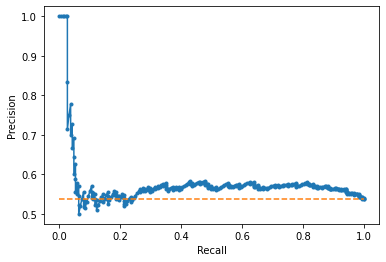

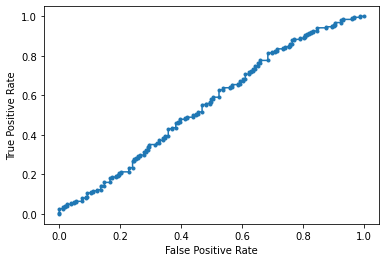

Accuracy: 57.14% Precision: 56.25% Recall: 90.96%
F1: 69.51% MCC: 0.1307
AUPRC: 57.72% AUROC: 55.42%
 accuracy [57.14285714285714]
 precision [56.25]
 recall [90.95744680851064]
 F1 [69.51219512195121]
 MCC [0.13073437824679954]
 AUPRC [57.71508241256166]
 AUROC [55.42257683215131]
2023-03-28 15:10:07.387541

Training # 2 1
2023-03-28 15:10:07.387731
2023-03-28 15:10:07.387788
Discriminator ZERO -1
Train 1:0 737:661 52.72%
Computed class weights: {0: 1.0574886535552193, 1: 0.9484396200814111}
Valid 1:0 198:157 55.77%
FIT
2023-03-28 15:10:07.435164


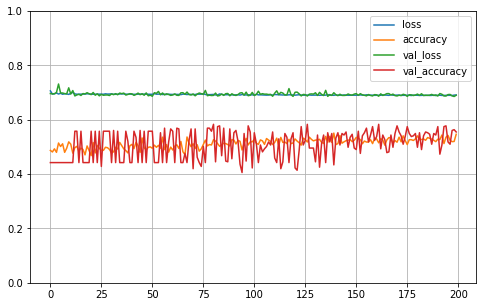


2023-03-28 15:10:49.413807

Testing # 2 1
2023-03-28 15:10:49.414254
2023-03-28 15:10:49.414295
PREDICT
2023-03-28 15:10:49.417023
Test 1:0 198:157 55.77%
Predict 1:0 258:97 72.68%
Test sizes (355, 1025) (355,)
Range of scores: 0.31203648 to 0.5414811
Score threshold 0.5
Confusion matrix
 [[ 48 109]
 [ 49 149]]
Normalized matrix
 [[0.13521127 0.30704225]
 [0.13802817 0.41971831]]


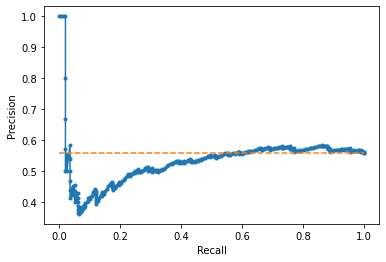

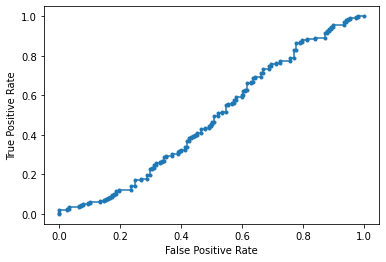

Accuracy: 55.49% Precision: 57.75% Recall: 75.25%
F1: 65.35% MCC: 0.0649
AUPRC: 53.57% AUROC: 48.39%
 accuracy [55.49295774647888]
 precision [57.751937984496124]
 recall [75.25252525252525]
 F1 [65.35087719298245]
 MCC [0.06492923841525385]
 AUPRC [53.56848276531701]
 AUROC [48.39477578331082]
2023-03-28 15:10:50.543363

Training # 2 2
2023-03-28 15:10:50.544100
2023-03-28 15:10:50.544160
Discriminator ZERO -1
Train 1:0 744:665 52.80%
Computed class weights: {0: 1.0593984962406016, 1: 0.9469086021505376}
Valid 1:0 191:153 55.52%
FIT
2023-03-28 15:10:50.601547


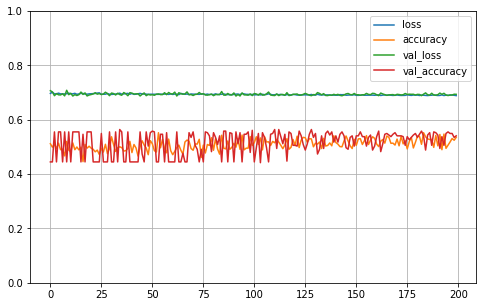


2023-03-28 15:11:32.650200

Testing # 2 2
2023-03-28 15:11:32.650653
2023-03-28 15:11:32.650692
PREDICT
2023-03-28 15:11:32.653003
Test 1:0 191:153 55.52%
Predict 1:0 235:109 68.31%
Test sizes (344, 1025) (344,)
Range of scores: 0.32141587 to 0.53211075
Score threshold 0.5
Confusion matrix
 [[ 52 101]
 [ 57 134]]
Normalized matrix
 [[0.15116279 0.29360465]
 [0.16569767 0.38953488]]


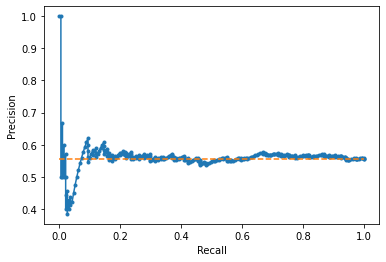

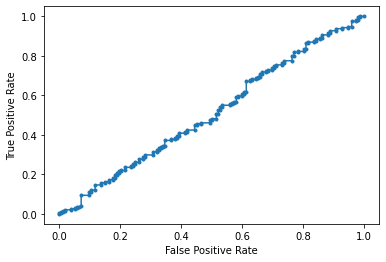

Accuracy: 54.07% Precision: 57.02% Recall: 70.16%
F1: 62.91% MCC: 0.0443
AUPRC: 55.96% AUROC: 51.13%
 accuracy [54.06976744186046]
 precision [57.02127659574469]
 recall [70.15706806282722]
 F1 [62.91079812206573]
 MCC [0.04426235978507725]
 AUPRC [55.96226344506784]
 AUROC [51.12582554836944]
2023-03-28 15:11:33.134129

Training # 2 3
2023-03-28 15:11:33.135178
2023-03-28 15:11:33.135235
Discriminator ZERO -1
Train 1:0 758:653 53.72%
Computed class weights: {0: 1.0803981623277181, 1: 0.9307387862796834}
Valid 1:0 177:165 51.75%
FIT
2023-03-28 15:11:33.186496


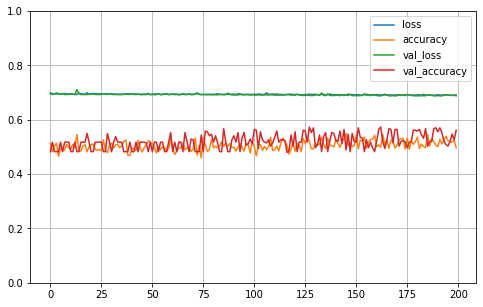


2023-03-28 15:12:15.310268

Testing # 2 3
2023-03-28 15:12:15.310680
2023-03-28 15:12:15.310941
PREDICT
2023-03-28 15:12:15.313113
Test 1:0 177:165 51.75%
Predict 1:0 249:93 72.81%
Test sizes (342, 1025) (342,)
Range of scores: 0.33358067 to 0.54147404
Score threshold 0.5
Confusion matrix
 [[ 54 111]
 [ 39 138]]
Normalized matrix
 [[0.15789474 0.3245614 ]
 [0.11403509 0.40350877]]


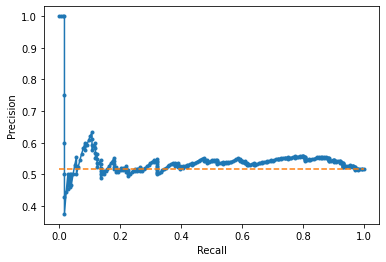

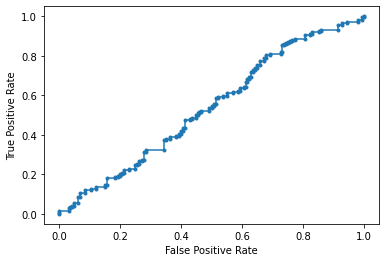

Accuracy: 56.14% Precision: 55.42% Recall: 77.97%
F1: 64.79% MCC: 0.1201
AUPRC: 54.33% AUROC: 53.95%
 accuracy [56.14035087719298]
 precision [55.42168674698795]
 recall [77.96610169491525]
 F1 [64.7887323943662]
 MCC [0.12008872423623813]
 AUPRC [54.32853742222035]
 AUROC [53.94624208183531]
2023-03-28 15:12:15.761047

Training # 2 4
2023-03-28 15:12:15.762962
2023-03-28 15:12:15.763034
Discriminator ZERO -1
Train 1:0 758:640 54.22%
Computed class weights: {0: 1.0921875, 1: 0.9221635883905013}
Valid 1:0 177:178 49.86%
FIT
2023-03-28 15:12:15.816210


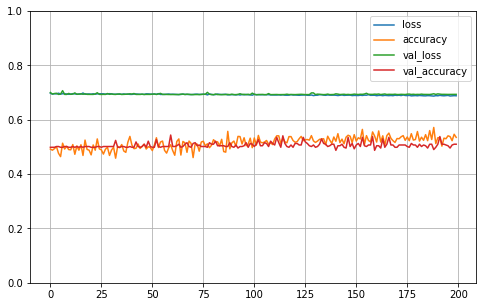


2023-03-28 15:12:44.970300

Testing # 2 4
2023-03-28 15:12:44.970391
2023-03-28 15:12:44.970433
PREDICT
2023-03-28 15:12:44.977011
Test 1:0 177:178 49.86%
Predict 1:0 225:130 63.38%
Test sizes (355, 1025) (355,)
Range of scores: 0.27861008 to 0.537759
Score threshold 0.5
Confusion matrix
 [[ 67 111]
 [ 63 114]]
Normalized matrix
 [[0.18873239 0.31267606]
 [0.17746479 0.32112676]]


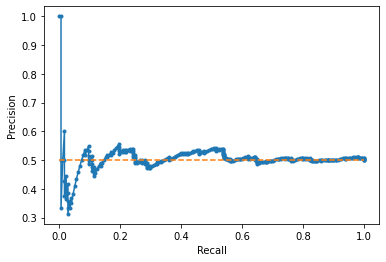

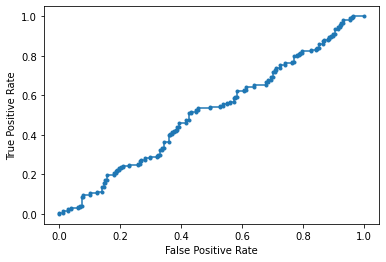

Accuracy: 50.99% Precision: 50.67% Recall: 64.41%
F1: 56.72% MCC: 0.0212
AUPRC: 50.47% AUROC: 51.42%
 accuracy [50.985915492957744]
 precision [50.66666666666667]
 recall [64.40677966101694]
 F1 [56.71641791044776]
 MCC [0.021247123638383287]
 AUPRC [50.469486325976355]
 AUROC [51.415603377134524]
2023-03-28 15:12:45.443296

Training # 2 5
2023-03-28 15:12:45.444162
2023-03-28 15:12:45.445098
Discriminator ZERO -1
Train 1:0 743:653 53.22%
Computed class weights: {0: 1.0689127105666156, 1: 0.9394347240915208}
Valid 1:0 192:165 53.78%
FIT
2023-03-28 15:12:45.492300


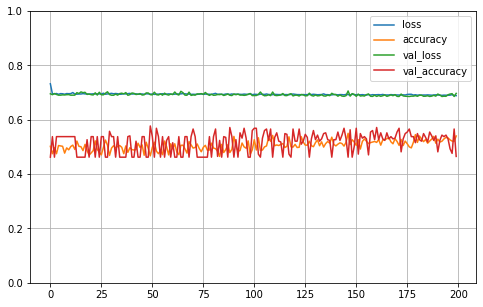


2023-03-28 15:13:14.490104

Testing # 2 5
2023-03-28 15:13:14.491598
2023-03-28 15:13:14.491916
PREDICT
2023-03-28 15:13:14.494629
Test 1:0 192:165 53.78%
Predict 1:0 1:356  0.28%
Test sizes (357, 1025) (357,)
Range of scores: 0.3186472 to 0.50231695
Score threshold 0.5
Confusion matrix
 [[165   0]
 [191   1]]
Normalized matrix
 [[0.46218487 0.        ]
 [0.53501401 0.00280112]]


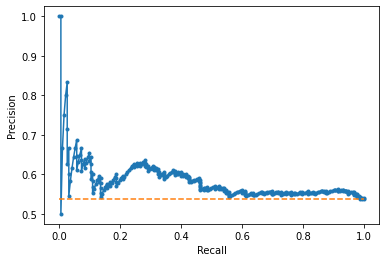

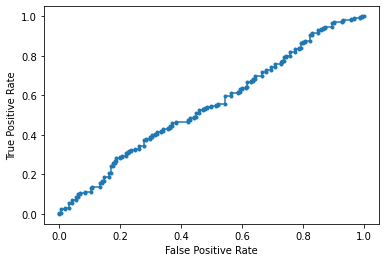

Accuracy: 46.50% Precision: 100.00% Recall: 0.52%
F1: 1.04% MCC: 0.0491
AUPRC: 58.19% AUROC: 54.97%
 accuracy [46.49859943977591]
 precision [100.0]
 recall [0.5208333333333333]
 F1 [1.0362694300518136]
 MCC [0.04913221671267361]
 AUPRC [58.19232207044565]
 AUROC [54.96527777777778]
2023-03-28 15:13:14.980594


In [80]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [81]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 52.45% std 3.64
 precision mean 59.15% std 14.54
 recall mean 61.95% std 24.27
 F1 mean 54.65% std 19.57
 MCC mean 0.05% std 0.06
 AUPRC mean 54.68% std 2.31
 AUROC mean 51.87% std 2.49
 accuracy [[46.95121951219512], [53.2258064516129], [50.750750750750754], [53.24324324324324], [57.14285714285714], [55.49295774647888], [54.06976744186046], [56.14035087719298], [50.985915492957744], [46.49859943977591]]
 precision [[51.13636363636363], [54.377880184331794], [55.223880597014926], [53.68852459016394], [56.25], [57.751937984496124], [57.02127659574469], [55.42168674698795], [50.66666666666667], [100.0]]
 recall [[50.56179775280899], [61.13989637305699], [60.0], [68.58638743455498], [90.95744680851064], [75.25252525252525], [70.15706806282722], [77.96610169491525], [64.40677966101694], [0.5208333333333333]]
 F1 [[50.847457627118644], [57.56097560975609], [57.51295336787565], [60.229885057471265], [69.51219512195121], [65.35087719298245], [62.91079812206573], [64.78873239436